In [ ]:
%run ~/interactive/spark.py

In [3]:
by_category = spark.table("content_gap_metrics.by_category").cache()
by_content_gap = spark.table("content_gap_metrics.by_content_gap").cache()
by_category_all_wikis = spark.table("content_gap_metrics.by_category_all_wikis").cache()
by_content_gap_all_wikis = spark.table("content_gap_metrics.by_content_gap_all_wikis").cache()

# Articles created for gender categories



In [ ]:
# rebucket into 3 gender categories
categories = ['female', 'male', 'non-binary']
gender3categories = F.udf(lambda c: c if c in ['female', 'male'] else 'non-binary',returnType='string')
gender_df = (by_category_all_wikis
    .where(f"content_gap='gender'")
    .withColumn('category', gender3categories('category'))
    )
    

<AxesSubplot: title={'center': 'cumulative article_created (log scale)'}, xlabel='time_bucket'>

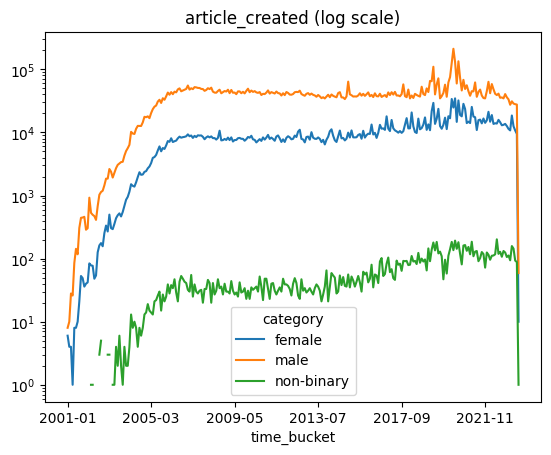

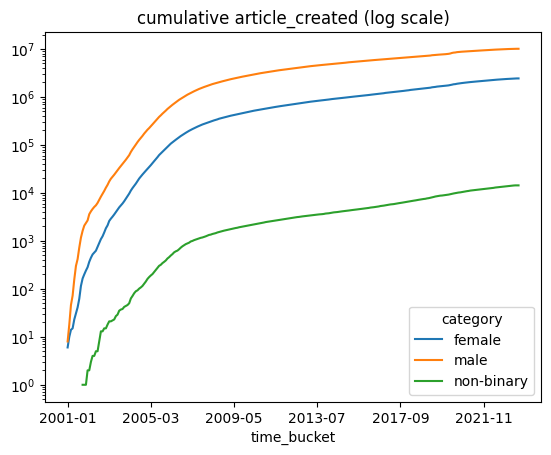

In [64]:
from pyspark.sql import Window

windowval = (Window.partitionBy('category').orderBy('time_bucket')
             .rowsBetween(Window.unboundedPreceding, 0))
cumsum_article_created = (gender_df
    .groupBy(['time_bucket','category'])
    .agg(
        F.sum('metrics.article_created').alias('article_created'),        
    )    
    .withColumn('cum_article_created', F.sum('article_created').over(windowval))
    .orderBy("time_bucket")
)
p = cumsum_article_created.toPandas()
pp = p.pivot(index="time_bucket",columns="category",values=["article_created","cum_article_created"])
pp.plot(y="article_created",logy=True,title="article_created (log scale)")
pp.plot(y="cum_article_created",logy=True,title="cumulative article_created (log scale)")

In [20]:
# as the article created metric can be re-aggregated
# we can verify the 2 data sources are returning the same totals
gender_df.groupBy("category").agg(F.sum("metrics.article_created")).show()
(by_category
    .where(f"content_gap='gender'")
    .withColumn('category', gender3categories('category'))
    .groupBy("category").agg(F.sum("metrics.article_created"))
    .show()
)

+----------+----------------------------+
|  category|sum(metrics.article_created)|
+----------+----------------------------+
|non-binary|                       14328|
|      male|                    10078523|
|    female|                     2429438|
+----------+----------------------------+



+----------+----------------------------+
|  category|sum(metrics.article_created)|
+----------+----------------------------+
|non-binary|                       14328|
|      male|                    10078523|
|    female|                     2429438|
+----------+----------------------------+



# Pageviews percentiles

There are much fewer articles about non-binary persons, but the mean pageviews per article are quite high



<AxesSubplot: title={'center': 'Mean pageviews'}, xlabel='time_bucket'>

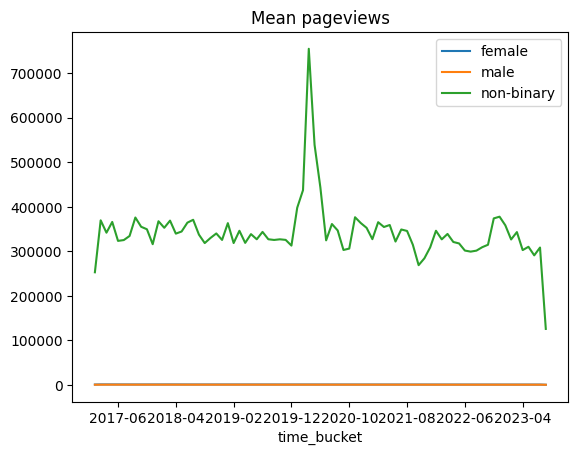

In [25]:
(by_category_all_wikis     
        .withColumn('category', gender3categories('category'))        
        .select('time_bucket', 'category', 'metrics.pageviews_mean')
        .groupby('time_bucket')
        .pivot("category", categories).sum("pageviews_mean")
        .orderBy('time_bucket')
).toPandas().plot(x='time_bucket', y=categories,title="Mean pageviews")

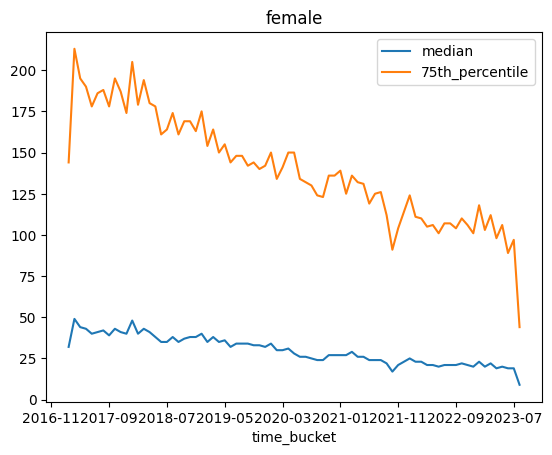

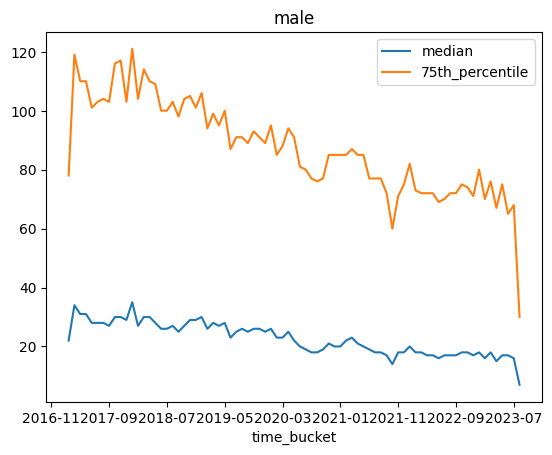

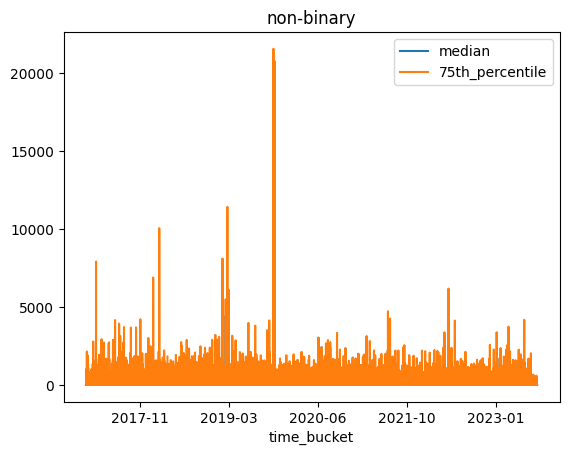

In [26]:
# The percentiles are generated for [0.05, 0.25, 0.5, 0.75, 0.95]
fields = {
    'median': F.col('quantiles.pageviews_quantiles').getItem(2),    
    '75th_percentile': F.col('quantiles.pageviews_quantiles').getItem(3),
    # '95th_percentile': F.col('quantiles.pageviews_quantiles').getItem(4),
}
fields = { n: c.alias(n) for n,c in fields.items() }

for category in categories:    
    (by_category_all_wikis     
        .withColumn('category', gender3categories('category'))
        .where(f"category='{category}'")
        .select('time_bucket', 'category', *fields.values())
        .orderBy('time_bucket')
    ).toPandas().plot(x='time_bucket', y=fields.keys(),title=category)
